## Run Seeded Campaigns

In [170]:
import random
import torch
import numpy as np
from tqdm.auto import trange

from botorch.models import SingleTaskGP
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.fit import fit_gpytorch_model
from botorch.optim import optimize_acqf
from botorch.acquisition import UpperConfidenceBound, ExpectedImprovement, LogExpectedImprovement, ProbabilityOfImprovement
from botorch.test_functions import Hartmann

from botorch.models.transforms import Standardize
from botorch.models.transforms.input import Normalize

from utils import *

from matplotlib import pyplot as plt
plt.style.use('ggplot')

torch.set_default_dtype(torch.float64)

In [171]:
seeds = np.loadtxt('seeds.txt', delimiter=',', dtype=int)

n_initial = 5 # set number of initial points
budget = 30-n_initial
n_campaigns = 25 # set number of campaigns to run

collection_y = np.zeros((n_campaigns, n_initial+budget), dtype=float)
collection_X = np.zeros((n_campaigns, 6, n_initial+budget), dtype=float)
collection_acqf = np.zeros((n_campaigns, n_initial+budget), dtype=float)
collection_model_params = np.zeros((n_campaigns, 8, n_initial+budget), dtype=float)

# generate starting data values
HART = Hartmann(dim=6, bounds=[(0,1)]*6, negate=True)

X_ = draw_random_samples(n=n_initial, dim=6)
y_ = torch.tensor([HART(x) for x in X_])[:,None]

# iterate through each campaign (random seed)
for campaign in (pbar0 := trange(n_campaigns, leave=True, colour="red")):
    set_seeds(seeds[campaign]) # set the random seed for the campaign
    X = X_.clone() # create a copy of df
    y = y_.clone() # create a copy of df

    # iterate through each trial up to budget - n_initial
    for trial in (pbar1 := trange(budget, leave=True)):

        # build the gp model
        gp = SingleTaskGP(
            train_X = X,
            train_Y = y,
            input_transform=Normalize(d=X.shape[-1]), # normalize X values
            outcome_transform=Standardize(m=y.shape[-1]) # standardize y values
        )

        # fit the model by maximizing the log marginal likelihood
        mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
        mll = fit_gpytorch_model(mll)

        collection_model_params[campaign,:,n_initial+trial] = torch.cat(
            [
                gp.covar_module.base_kernel.lengthscale[0],
                gp.covar_module.outputscale.view(1),
                gp.likelihood.noise
            ]
        ).detach().numpy()

        bounds = torch.tensor([[0.0]*X.shape[-1], [1.0]*X.shape[-1]])

        X_new, acq_value = optimize_acqf(
            # acq_function= UpperConfidenceBound(gp, beta=2),
            # acq_function= ExpectedImprovement(gp, best_f=y.max()),
            # acq_function= LogExpectedImprovement(gp, best_f=y.max()),
            acq_function= ProbabilityOfImprovement(gp, best_f=y.max(), maximize=True),
            bounds=bounds,
            q=1, # how many new points to generate
            num_restarts = 20, # how many times to restart the optimizer
            raw_samples = 250 # how many initial points to sample acqf space from
        )

        collection_acqf[campaign, n_initial+trial] = acq_value.item()

        X = torch.cat([X, X_new])
        y = torch.cat([y, HART(X=X_new)[:,None]])

        pbar0.set_description(f"Processing Trial {trial+1} of Campaign {campaign+1}")
        pbar1.set_description(f"Campaign {campaign+1} | Best Value {round(torch.max(y).item(),3)}")

    collection_y[campaign,:] = y.flatten()
    collection_X[campaign, :, :] = X.T

np.save('runs_log/Hartmann6/P--/collection_y.npy', collection_y)
np.save('runs_log/Hartmann6/P--/collection_X.npy', collection_X)
np.save('runs_log/Hartmann6/P--/collection_acqf.npy', collection_acqf)
np.save('runs_log/Hartmann6/P--/collection_model_params.npy', collection_model_params)

Campaign 1 | Best Value 1.073: 100%|██████████| 25/25 [00:22<00:00,  1.10it/s]t/s]
Campaign 2 | Best Value 1.079: 100%|██████████| 25/25 [00:21<00:00,  1.16it/s], 22.78s/it]
Campaign 3 | Best Value 1.074: 100%|██████████| 25/25 [00:20<00:00,  1.19it/s], 22.05s/it]
Campaign 4 | Best Value 1.075: 100%|██████████| 25/25 [00:21<00:00,  1.19it/s], 21.54s/it]
Campaign 5 | Best Value 1.075: 100%|██████████| 25/25 [00:21<00:00,  1.17it/s], 21.33s/it]
Campaign 6 | Best Value 1.155: 100%|██████████| 25/25 [00:20<00:00,  1.19it/s], 21.37s/it]
Campaign 7 | Best Value 1.076: 100%|██████████| 25/25 [00:21<00:00,  1.16it/s], 21.24s/it]
Campaign 8 | Best Value 1.067: 100%|██████████| 25/25 [00:22<00:00,  1.13it/s], 21.32s/it]
Campaign 9 | Best Value 1.075: 100%|██████████| 25/25 [00:23<00:00,  1.08it/s], 21.58s/it]
Campaign 10 | Best Value 1.074: 100%|██████████| 25/25 [00:22<00:00,  1.13it/s], 22.06s/it]
Campaign 11 | Best Value 1.075: 100%|██████████| 25/25 [00:21<00:00,  1.15it/s]0, 22.06s/it]
Camp

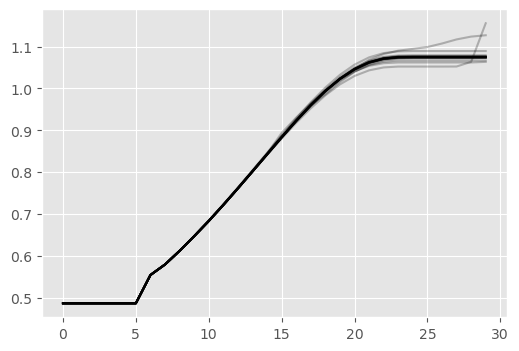

In [174]:
y = np.load('runs_log/Hartmann6/PI/collection_y.npy')

fig, ax = plt.subplots(figsize=(6,4))
ax.plot(np.maximum.accumulate(y.T), color='black', alpha=0.25)
plt.show()

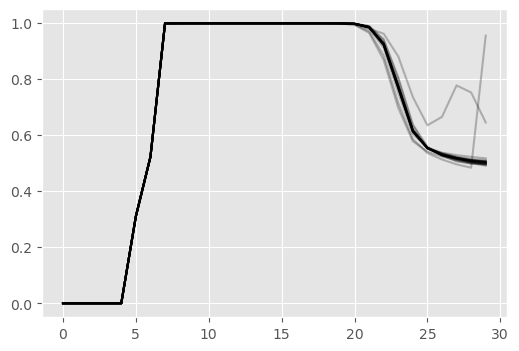

In [175]:
acq = np.load('runs_log/Hartmann6/PI/collection_acqf.npy')

fig, ax = plt.subplots(figsize=(6,4))
ax.plot(acq.T, color='black', alpha=0.25)
plt.show()
